# Richards model prediction of Covid-19 for Cuba

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # plots
import pymc3 as pm
import arviz as az

## Load data

In [72]:
# Global parameters
country = 'Cuba'
ndays_limit = 36
epidemic_start = 10
x_data_label = 'days_since_{}'.format(epidemic_start)

# loading data
oper_file_path1 = 'data/cuba_data.csv'
df_input = pd.read_csv(oper_file_path1, sep=',', decimal='.', error_bad_lines=False, parse_dates=['date'])
df_input.index = df_input['date']

# Prepare data for model training
df = df_input[df_input['confirmed'] > epidemic_start][['date', 'confirmed', 'new_cases']].copy()
df.columns = ['date', 'acumulado', 'new_cases']
df[x_data_label] = list(np.arange(df.shape[0]))
print(df.tail(10))

                 date  acumulado  new_cases  days_since_10
date                                                      
2020-04-18 2020-04-18       1035         49             31
2020-04-19 2020-04-19       1087         52             32
2020-04-20 2020-04-20       1137         50             33
2020-04-21 2020-04-21       1189         52             34
2020-04-22 2020-04-22       1235         46             35
2020-04-23 2020-04-23       1285         50             36
2020-04-24 2020-04-24       1337         52             37
2020-04-25 2020-04-25       1369         32             38
2020-04-26 2020-04-26       1389         20             39
2020-04-27 2020-04-27       1437         48             40


## Split data into: train and test

In [75]:
df_train = df.loc['2020-03-18':'2020-04-25']
df_test = df.loc['2020-04-26':'2020-04-27']
df_test

,date,acumulado,new_cases,days_since_10
date,,,,
2020-04-26,2020-04-26,1389,20,39
2020-04-27,2020-04-27,1437,48,40


## Model fit

In [76]:
x_values = df_train[x_data_label].values
y_values = df_train.acumulado.astype('float64').values
dt_until = str(df_train[df_train[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]).replace('-', '')
with pm.Model() as richards_model:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)
    K = pm.Uniform('K', 100, 1000000, testval=5000)  # carrying capacity
    rate = pm.Normal('rate', 0.3, 0.05, testval=0.45)  # growth rate
    a = pm.Uniform('a', 0.1, 10.0, testval=0.25)
    x0 = pm.Uniform('x0', 1, 200, testval=15)
    T = pm.Uniform('T', 1, 3, testval=1.2)
    R0 = pm.Deterministic('R0', np.exp(rate * T))

    # Create likelihood for data
    x_data = pm.Data("x_data", x_values)
    y_data = pm.Data("y_data", y_values)
    mu = K * (1 + np.exp(-rate * a * (x_data - x0 - (np.log(a) / (rate * a))))) ** (-1 / a)
    y = pm.Normal('y', mu=mu, tau=sigma, observed=y_data)
    
with richards_model:
    
    # Sample posterior
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(4000, tune=4000, cores=7, start=start, target_accept=.95, random_seed=1234)

logp = -164.39, ||grad|| = 55.796: 100%|██████████| 71/71 [00:00<00:00, 2794.55it/s]    
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [T, x0, a, rate, K, sigma]
Sampling 7 chains, 0 divergences: 100%|██████████| 56000/56000 [03:50<00:00, 243.33draws/s]
The number of effective samples is smaller than 25% for some parameters.


## Model summary

In [77]:
az.summary(az.from_pymc3(trace))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
rate,0.313,0.039,0.240,0.386,0.000,0.000,8612.0,8612.0,8484.0,11116.0,1.0
sigma[0],0.010,0.002,0.006,0.015,0.000,0.000,16563.0,16563.0,16203.0,16116.0,1.0
K,2077.492,70.686,1946.542,2213.324,0.852,0.602,6889.0,6889.0,6896.0,9400.0,1.0
a,0.262,0.047,0.180,0.349,0.001,0.000,7531.0,7471.0,7733.0,9943.0,1.0
x0,27.636,0.395,26.898,28.379,0.004,0.003,8855.0,8855.0,8854.0,11744.0,1.0
T,2.005,0.575,1.121,2.996,0.004,0.003,20681.0,20128.0,18983.0,13465.0,1.0
R0,1.909,0.388,1.305,2.587,0.003,0.002,16610.0,16034.0,16669.0,14266.0,1.0


In [78]:
pm.backends.tracetab.trace_to_dataframe(trace)

,rate,sigma__0,K,a,x0,T,R0
0,0.309085,0.012177,2034.596173,0.263975,27.312889,1.901794,1.800053
1,0.251646,0.009932,2003.264934,0.344310,27.515322,1.317214,1.393017
2,0.242624,0.009620,2030.093399,0.354335,27.824208,2.302790,1.748418
3,0.315301,0.011673,2012.129381,0.261574,27.101554,2.526745,2.218177
4,0.332166,0.011447,2102.318434,0.231950,27.655723,2.007137,1.947805
...,...,...,...,...,...,...,...
27995,0.393954,0.014894,2134.527827,0.188281,27.640929,2.133018,2.317090
27996,0.388750,0.013873,2125.104213,0.190710,27.616172,1.973616,2.153820
27997,0.373284,0.008996,2156.242758,0.200994,27.832271,2.533967,2.575105
27998,0.273318,0.011831,2048.553777,0.304052,27.660846,1.532453,1.520207


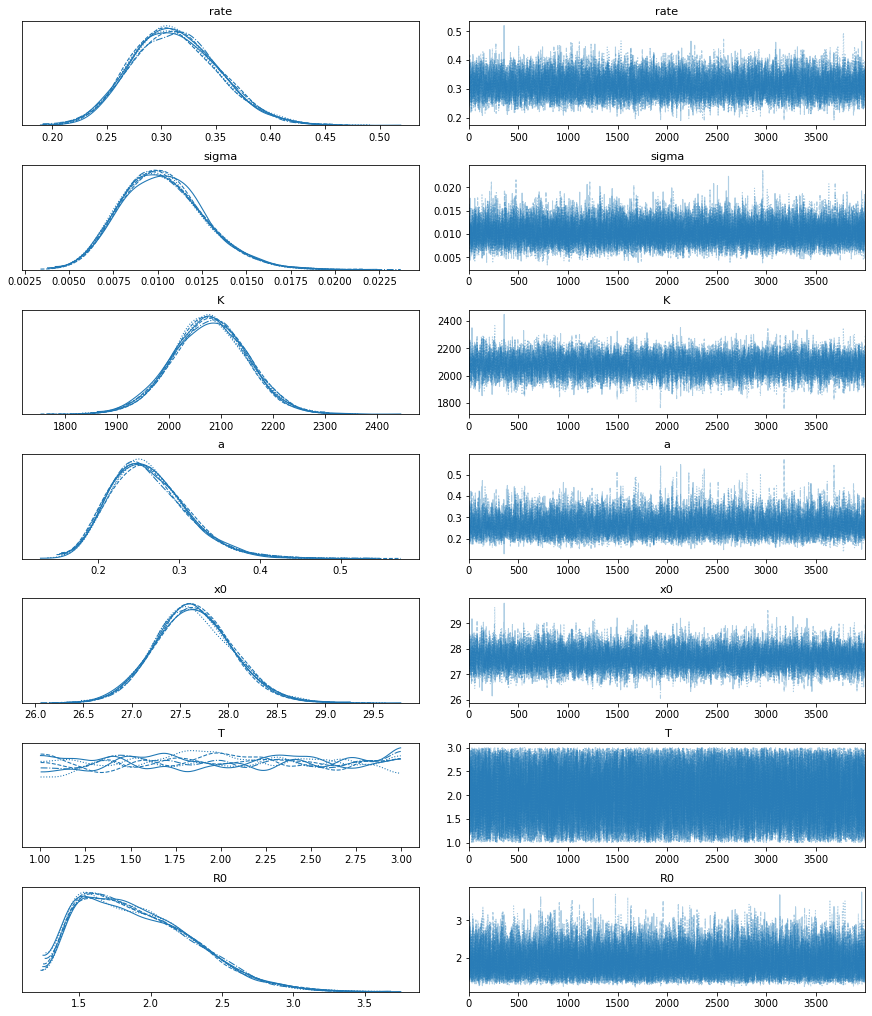

In [79]:
az.plot_trace(trace, compact=True);

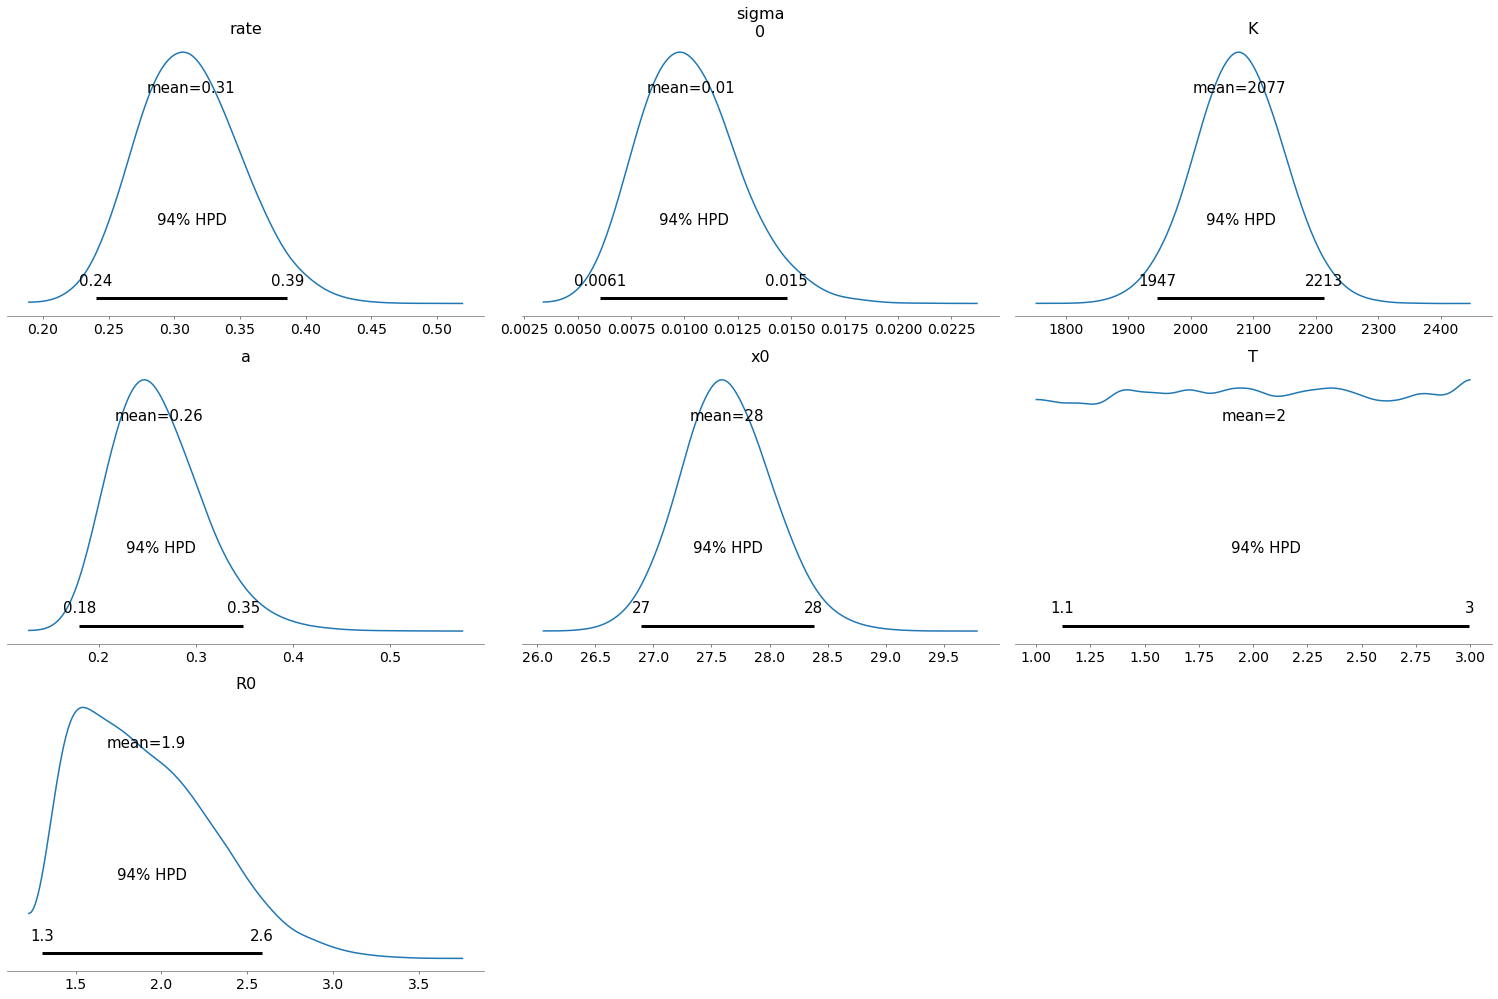

In [80]:
az.plot_posterior(trace);

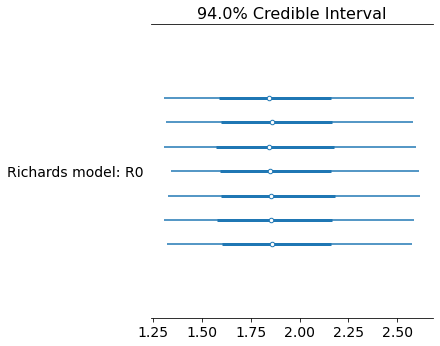

In [81]:
az.plot_forest([trace], model_names=["Richards model"], var_names=['R0']);

In [82]:
# Fitted parameters
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
txt = """
        --------------------------------------
        Fitted parameters for {}:
        --------------------------------------
        Growth rate: {}
        Turning point: {}
        Final size of epidemic: {}
        Basic reproduction number (R0): {}
        --------------------------------------
     """.format(country, *f_values)
print(txt)


        --------------------------------------
        Fitted parameters for Cuba:
        --------------------------------------
        Growth rate: 0.31
        Turning point: 27.64
        Final size of epidemic: 2077.49
        Basic reproduction number (R0): 1.91
        --------------------------------------
     


## Model predictions

In [83]:
# ========== Compute predictions =============
np.random.seed(12345)
tp = int(round(np.percentile(trace['x0'], 50, axis=0)))
h = tp # 27  # number points to prediction ahead
with richards_model:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, len(y_values) + h)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({"x_data": x_data})
    pm.set_data({"y_data": y_data})

    # Sample posterior predictive
    post_pred_final = pm.sample_posterior_predictive(trace, samples=100)

# Prediction of cumulative cases 
y_min_final = np.percentile(post_pred_final['y'], 2.5, axis=0)
y_max_final = np.percentile(post_pred_final['y'], 97.5, axis=0)
y_fit_final = np.percentile(post_pred_final['y'], 50, axis=0)

# Prediction of incidence of new cases
dy_fit_final = np.percentile(trace['rate'], 50, axis=0) * y_fit_final * (1 - (y_fit_final / np.percentile(trace['K'], 50, axis=0)) ** np.percentile(trace['a'], 50, axis=0))

/home/jrd/.local/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 137.06it/s]


In [84]:
from sklearn.metrics import mean_squared_error
rms_train = round(np.sqrt(mean_squared_error(df_train['acumulado'], y_fit_final[df_train[x_data_label]])),2)
rms_test = round(np.sqrt(mean_squared_error(df_test['acumulado'], y_fit_final[df_test[x_data_label]])),2)
print('RMSE-train: {}'.format(rms_train))
print('RMSE-test: {}'.format(rms_test))

RMSE-train: 9.76
RMSE-test: 23.77


### Plot prediction of comulative cases

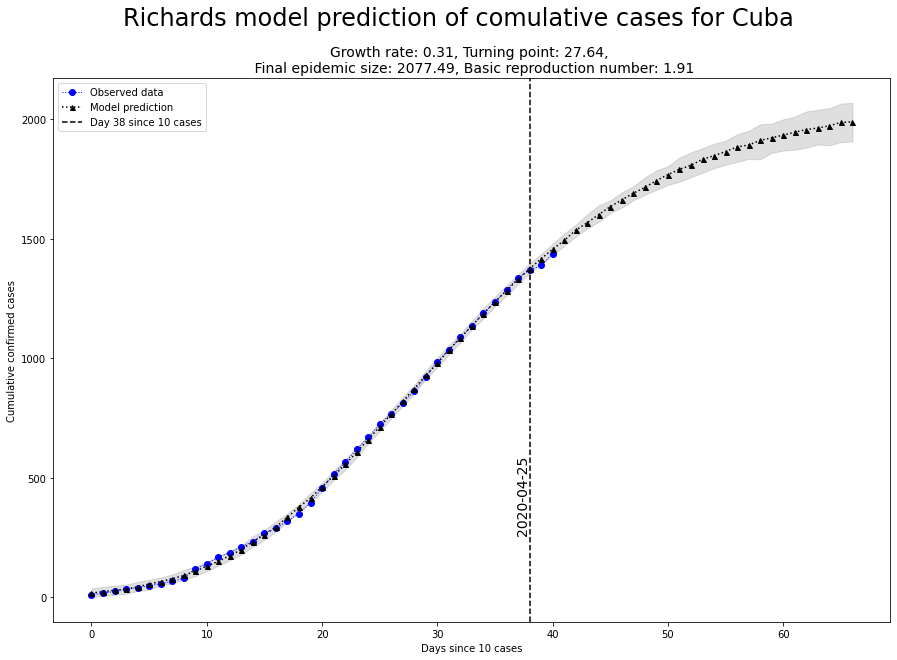

In [85]:
# Plot prediction of comulative cases
#ymax_limit = max(max(y_fit_final), df.acumulado.astype('float64').max()) * 1.10
yref_ycoord_0 = min(np.median(y_fit_final), df.acumulado.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['acumulado'], 'b', marker='o', ls=':', lw=1, label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), y_fit_final,
         'k', marker='^', ls=':', ms=5, mew=1, label='Model prediction')
plt.fill_between(np.arange(0, post_pred_final['y'].shape[1]), y_min_final, y_max_final, color='0.5', alpha=0.25)
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df_train[df_train[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
plt.suptitle('Richards model prediction of comulative cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
ax.set(xlabel='Days since {} cases'.format(epidemic_start))
ax.set(ylabel='Cumulative confirmed cases')
plt.legend(loc='upper left')
# plt.savefig('results/{}/cumulative_prediction_plot.png'.format(country))
plt.show()

### Plot prediction of incidence of new cases

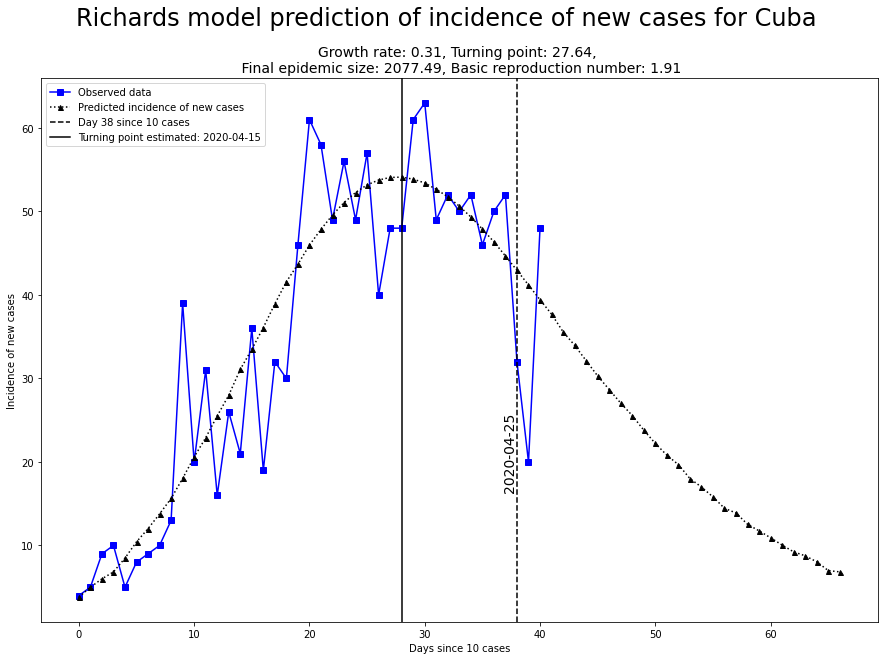

In [86]:
# Incidence of new cases prediction
yref_ycoord_0 = min(np.median(dy_fit_final), df.new_cases.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['new_cases'], 'b', marker='s', ls='-', label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), dy_fit_final, 'k', marker='^', ls=':', ms=5, mew=1,
         label='Predicted incidence of new cases')
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
if tp in list(df[x_data_label].values):
    tp_date = df[df[x_data_label] == tp].date.values[0]
    ax.axvline(tp, ls='-', color='k', label='Turning point estimated: {}'.format(str(tp_date)[:10]))
plt.xlabel('Days since {} cases'.format(epidemic_start))
plt.ylabel('Incidence of new cases')
plt.suptitle('Richards model prediction of incidence of new cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
plt.legend(loc='upper left')
# plt.savefig('results/{}/newcases_prediction_plot.png'.format(country))
plt.show()

## Refit the model with full data

In [87]:
x_values = df[x_data_label].values
y_values = df.acumulado.astype('float64').values
with pm.Model() as richards_model:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)
    K = pm.Uniform('K', 100, 1000000, testval=5000)  # carrying capacity
    rate = pm.Normal('rate', 0.3, 0.05, testval=0.45)  # growth rate
    a = pm.Uniform('a', 0.1, 10.0, testval=0.25)
    x0 = pm.Uniform('x0', 1, 200, testval=15)
    T = pm.Uniform('T', 1, 3, testval=1.2)
    R0 = pm.Deterministic('R0', np.exp(rate * T))

    # Create likelihood for data
    x_data = pm.Data("x_data", x_values)
    y_data = pm.Data("y_data", y_values)
    mu = K * (1 + np.exp(-rate * a * (x_data - x0 - (np.log(a) / (rate * a))))) ** (-1 / a)
    y = pm.Normal('y', mu=mu, tau=sigma, observed=y_data)
    
with richards_model:
    
    # Sample posterior
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(4000, tune=4000, cores=7, start=start, target_accept=.95, random_seed=1234)

logp = -173.56, ||grad|| = 11.061: 100%|██████████| 68/68 [00:00<00:00, 2483.98it/s]    
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [T, x0, a, rate, K, sigma]
Sampling 7 chains, 0 divergences: 100%|██████████| 56000/56000 [03:42<00:00, 251.91draws/s]
The number of effective samples is smaller than 25% for some parameters.


## Save the model for further analysis

In [11]:
import pickle 

with open('results/Cuba/model_data.pkl', 'wb') as buff:
    pickle.dump({'model': richards_model, 'trace': trace}, buff)